# Compare the base model with the new one

In [ ]:
!tar -xzf dataset-full.tar.gz

In [1]:
import os
import boto3
from ultralytics import YOLO

In [2]:
BASE_MODEL_BUCKET = "model-registry"
BASE_MODEL_PATH = "base_model.pt"
NEW_MODEL_PATH = "models/new-model.pt"

MAP_THRESHOLD = float(os.getenv("map_threshold", 0.8))

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
AWS_S3_ENDPOINT = os.getenv("AWS_S3_ENDPOINT")

In [3]:
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)
client = session.client("s3", endpoint_url=AWS_S3_ENDPOINT)

## Get the models

In [4]:
client.download_file(BASE_MODEL_BUCKET, BASE_MODEL_PATH, "/tmp/base-model.pt")
client.download_file(AWS_S3_BUCKET, NEW_MODEL_PATH, "/tmp/new-model.pt")

## Base Model Results

In [5]:
model = YOLO("/tmp/base-model.pt")
results = model.val(data="utils/data.yaml", split="test")

Ultralytics YOLOv8.2.60 🚀 Python-3.9.18 torch-2.2.2+cu121 CUDA:0 (NVIDIA A10G, 22724MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /opt/app-root/src/rhoai-tot/demos/trains/dataset/labels/val.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


                   all         14         25      0.429      0.285      0.294      0.139
            SpeedLimit          9          9      0.571      0.444      0.413      0.213
           DangerAhead         10         16      0.286      0.125      0.175     0.0653
Speed: 0.2ms preprocess, 7.4ms inference, 0.0ms loss, 28.1ms postprocess per image
Results saved to runs/detect/val3



image 1/1 /opt/app-root/src/rhoai-tot/demos/trains/utils/sample-inference-example.jpg: 480x640 1 SpeedLimit, 87.1ms
Speed: 0.9ms preprocess, 87.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


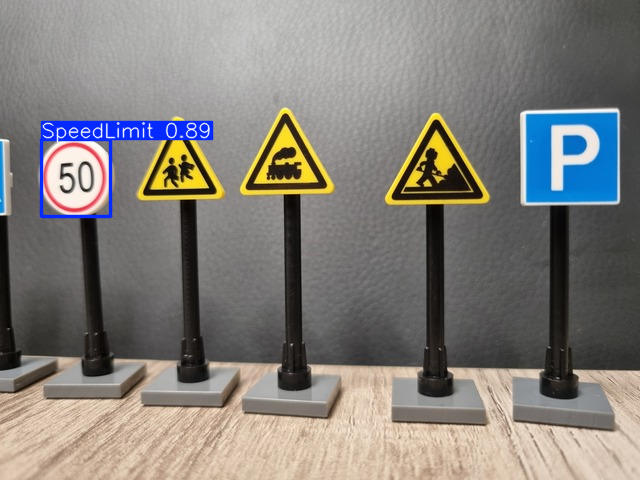

In [6]:
res = model("utils/sample-inference-example.jpg")
res[0].show()

## New Model Results

In [7]:
new_model = YOLO("/tmp/new-model.pt")
results = new_model.val(data = "utils/data.yaml", split="test")

Ultralytics YOLOv8.2.60 🚀 Python-3.9.18 torch-2.2.2+cu121 CUDA:0 (NVIDIA A10G, 22724MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /opt/app-root/src/rhoai-tot/demos/trains/dataset/labels/val.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


                   all         14         25      0.876       0.84      0.895      0.614
            SpeedLimit          9          9      0.753      0.778      0.852      0.579
           DangerAhead         10         16          1      0.901      0.937      0.649
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val4



image 1/1 /opt/app-root/src/rhoai-tot/demos/trains/utils/sample-inference-example.jpg: 480x640 1 SpeedLimit, 3 DangerAheads, 6.7ms
Speed: 0.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


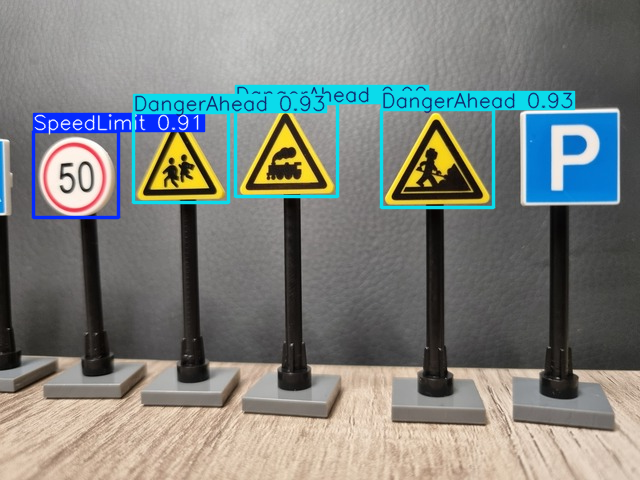

In [8]:
res = new_model("utils/sample-inference-example.jpg")
res[0].show()

## Make the Pipeline Fail Based on a Minimal mAP50 Threshold

In [9]:
assert results.results_dict["metrics/mAP50(B)"] >= MAP_THRESHOLD